In [380]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option("display.max_columns",101)
RANDOM_STATE = 42
import random
random.seed(const.RANDOM_STATE)

In [381]:
import const

<module 'const' from 'const.pyc'>

In [396]:
prior_data = pd.read_csv(const.EXTEND_PRIOR_PATH)

In [397]:
prior_data.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


#### 使用10W的，即0.01的数据进行测试，日后使用完整的数据集进行测试。考虑到prior的特性，每次抽样都是从所有数据中进行的

In [382]:
total_train = pd.read_csv(const.SAMPLE_TRAIN_FC_PATH)
num_data = total_train.shape[0]

In [383]:
total_train[total_train.label == 1].shape

(137998, 41)

In [384]:
def split_train_test(data, key, percentage=0.2):
    """
    根据key值来划分数据为train和test数据
    """
    key_id_list = list(data[key].value_counts().index)
    sample_key_set = set(random.sample(key_id_list, int(len(key_id_list) * percentage)))

    key_id_data_list = data[key].values
    sample_index_flag = range(data.shape[0])
    for idx, value in enumerate(key_id_data_list):
        if value in sample_key_set:
            sample_index_flag[idx] = True
        else:
            sample_index_flag[idx] = False

    test_df = data[sample_index_flag]
    train_df = data[[not x for x in sample_index_flag]]
    return train_df, test_df

#### n_train数据由于是unblanced，所以需要进行重新采样处理

In [385]:
def get_sample_negative_data(data, sample_percentage):
    order_id_index = data.groupby(const.OID)[const.PID].apply(list).reset_index()
    result = data.set_index([const.OID, const.PID])
    sample_index_list = []
    for order_id, value in order_id_index.iterrows():
        order_id = value['order_id']
        product_id_list = value['product_id']
        num = int(len(product_id_list) * sample_percentage)
        if num <= 0:
            continue

        product_sample = random.sample(product_id_list, num)
        sample_index_list.extend([(order_id, product_id) for product_id in product_sample])

    new_data = result.ix[sample_index_list]
    new_data.reset_index()
    return new_data

In [386]:
n_train, n_test = split_train_test(total_train, const.OID, 0.2)
negative_data = n_train[n_train.label == 0]
positive_data = n_train[n_train.label == 1]

num_positive = positive_data.shape[0]
num_negative = negative_data.shape[0]

target_num = 2 * num_positive
sample_negative_data = get_sample_negative_data(negative_data, target_num / float(num_negative))
train_data = pd.concat([sample_negative_data, positive_data])

drop_list = ['order_id', 'product_id', 'reordered', 'add_to_cart_order', 'user_id', 'eval_set', 'order_number']
train_data.drop(drop_list, axis=1, inplace=True)
train_validate_data = n_test.drop(drop_list, axis=1)

In [388]:
import lightgbm as lgb
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'num_leaves': 72,
        'max_depth': 10,
        'metric': ['auc'],
        'feature_fraction': 0.85,
        'bagging_fraction': 0.95,
        'bagging_freq': 5,
        'learning_rate': 0.1,
        'min_child_samples': 50,
        'reg_lambda': 0.7,
        'n_estimators': 50,
        'silent': True
    }

train_df = train_data.drop(['label'], axis=1)
train_labels = train_data['label']
print('light GBM train :-)')
clf = lgb.LGBMClassifier(**params)
categorical_feature = ['order_dow', 'order_hour_of_day',]
result = clf.fit(
    train_df,
    train_labels,
    categorical_feature=categorical_feature,
)

light GBM train :-)


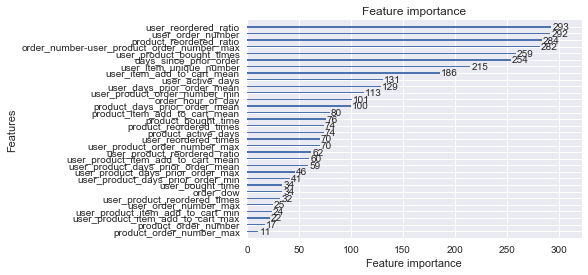

In [389]:
lgb.plot_importance(clf)

#### use train_validate_data to validate

In [390]:
validate_df = train_validate_data.drop(['label'], axis=1)
validate_labels = train_validate_data['label']

In [391]:
predict_y = clf.predict_proba(validate_df)[:, 1]

#### 求f值

In [392]:
order_id_index = n_test.groupby(const.OID)['label'].apply(list).reset_index()
def mean_f1_score(order_id_index, predict_y):
    f_score_total = 0
    n = 0
    idx = 0
    for _, value in order_id_index.iterrows():
        label_list = value['label']
        predict_label_list = predict_y[idx:idx+len(label_list)]
        
        if not np.any(label_list) and not np.any(predict_label_list):
            f_score = 1
        else:
            f_score = metrics.f1_score(predict_label_list, label_list)
        f_score_total += f_score
        idx += len(label_list)
        n += 1
        
    return f_score_total / n

In [393]:
best_score = 0
best_margin = 0

for margin in range(1, 100):
    threshold = margin / float(100)
    predict_result = predict_y >= threshold
    #score = metrics.f1_score(validate_labels.values, predict_result)
    score = mean_f1_score(order_id_index, predict_result)
    if score > best_score:
        best_score = score
        best_margin = threshold

In [394]:
print best_score, best_margin

0.323757695298 0.06
